### Q5. Natural Language Processing in Python: Supervised Machine Learning 

Create a Large Language Model (LLM) that classifies sentences into two categories (inflation and exchange rate) using RoBERTa. 

### Data Loading and Preparation

This part of the code imports libraries, loads labeled sentence data, checks basic statistics, and displays the label distribution. It separates the data into two categories ("inflation" and "exchange rate") and creates a balanced training set by selecting equal samples from each label. The remaining data is used as the test set, allowing for a structured approach to training and evaluation.


In [3]:
# Import libraries

import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter

In [4]:
# Load data
data = pd.read_csv("Labeled sentences.csv", encoding="ISO-8859-1")

# Display the first few rows
data.head()

,sentence,label
0,"As yet, there had been little sign of the dimi...",inflation
1,Annual CPI inflation had been unchanged in Jun...,inflation
2,CPI inflation had fallen to 2.4% in June.,inflation
3,But the size and timing of any effect at the r...,inflation
4,the evolution of inflation expectations.,inflation


In [5]:
print(data.describe())

                                                 sentence     label 
count                                                 218        218
unique                                                217          2
top     the rate of inflation will deviate downward fr...  inflation
freq                                                    2        131


In [6]:
print(Counter(data['label ']))

Counter({'inflation': 131, 'exchange rate': 87})


In [7]:
# Separate the data by label
inflation_data = data[data['label '] == 'inflation'].head(12)
exchange_rate_data = data[data['label '] == 'exchange rate'].head(12)

# Combine to form the training set
train_data = pd.concat([inflation_data, exchange_rate_data]).reset_index(drop=True)

# Remaining samples for testing
test_data = data.drop(train_data.index).reset_index(drop=True)

print("Training Data:\n", train_data)
print("Testing Data:\n", test_data)

Training Data:
                                              sentence         label 
0   As yet, there had been little sign of the dimi...      inflation
1   Annual CPI inflation had been unchanged in Jun...      inflation
2           CPI inflation had fallen to 2.4% in June.      inflation
3   But the size and timing of any effect at the r...      inflation
4           the evolution of inflation expectations.       inflation
5   The recent strength of the global economy had ...      inflation
6   The recent decline in goods price inflation su...      inflation
7   And the range of more medium to long-term meas...      inflation
8   With regard to prices, based on the assumption...      inflation
9   With regard to prices, there is a possibility ...      inflation
10  core goods and services CPI inflation were bot...      inflation
11  the rate of inflation will deviate downward fr...      inflation
12  The sterling effective exchange rate index had...  exchange rate
13  The changes in

#### Next step: 

The `TextDataset` class prepares text data for supervised learning by tokenizing and encoding sentences, padding or truncating them to a specified maximum length, and converting labels to tensors. This class provides each sample as a dictionary of inputs (`input_ids`, `attention_mask`) and corresponding labels, making it compatible with PyTorch’s `DataLoader` for batch processing.


In [9]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

### Mapping Labels to Integers

To prepare the dataset for classification, this step maps categorical labels (`"inflation"` and `"exchange rate"`) to integers (0 and 1) for compatibility with the model. The sentences and mapped labels are then stored as lists for easy access during tokenization and dataset preparation.


In [11]:
# Map labels to integers
label_map = {"inflation": 0, "exchange rate": 1}
train_texts = train_data['sentence'].tolist()
train_labels = train_data['label '].map(label_map).tolist()
test_texts = test_data['sentence'].tolist()
test_labels = test_data['label '].map(label_map).tolist()

### Load RoBERTa Model and Tokenizer

This step initializes the `RoBERTa` model and tokenizer. Using `"roberta-base"`, we load a pretrained RoBERTa model configured for sequence classification with two labels (e.g., `"inflation"` and `"exchange rate"`). The tokenizer will handle tokenizing and encoding sentences in the format required by RoBERTa.


In [13]:
model_id = "roberta-base"
model = RobertaForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained(model_id)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepare Datasets and Train Model

This code prepares the training and test datasets using the `TextDataset` class and configures `TrainingArguments` for fine-tuning RoBERTa. It defines metrics for model evaluation (accuracy, precision, recall, F1) and a custom callback to track training loss. Finally, the `Trainer` class initializes and trains the model, using the defined datasets, metrics, and callback.


In [15]:
# Prepare datasets
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    logging_steps=10,
    weight_decay=0.01,  # Regularization
    report_to="none"  # Disable default logging to console
)

# Define metric computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.losses.append(logs["loss"])

loss_callback = LossCallback()

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[loss_callback]
)

# Train the Model
trainer.train()

C:\Users\kumar\anaconda3\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.707214,0.386598,0.557621,0.386598,1.000000
2,0.696800,0.609941,0.979381,0.974026,0.949367,1.000000
3,0.696800,0.249376,0.974227,0.967742,0.937500,1.000000
4,0.405500,0.068777,0.989691,0.986842,0.974026,1.000000
5,0.065600,0.045892,0.994845,0.993377,0.986842,1.000000


TrainOutput(global_step=30, training_loss=0.38930970430374146, metrics={'train_runtime': 305.6806, 'train_samples_per_second': 0.393, 'train_steps_per_second': 0.098, 'total_flos': 7893331660800.0, 'train_loss': 0.38930970430374146, 'epoch': 5.0})

### Model Evaluation: Confusion Matrix and ROC Curve

This code evaluates the model's predictions on the test set by generating a confusion matrix, which visualizes classification accuracy across categories ("Inflation" and "Exchange Rate").


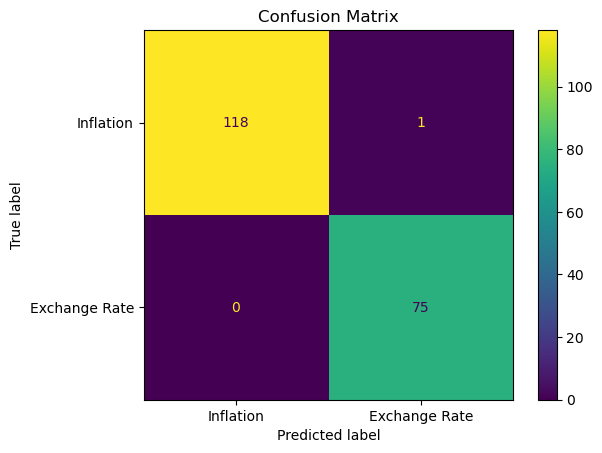

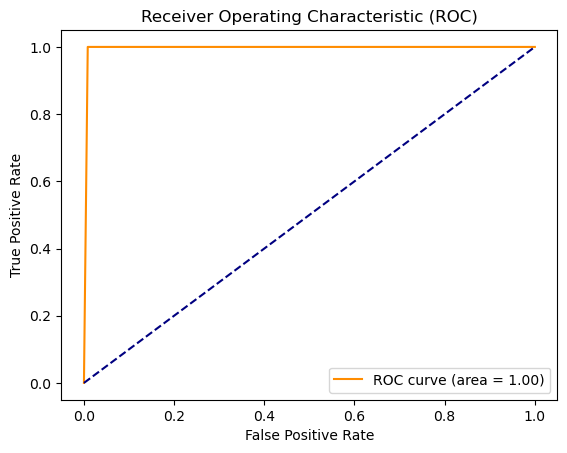

In [17]:
# Collect predictions on the test set
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)

# Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
ConfusionMatrixDisplay(cm, display_labels=["Inflation", "Exchange Rate"]).plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, pred_labels)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

### Step 6: Predict on New Data

This code loads a new dataset of sentences, tokenizes and encodes them for prediction, and uses the trained model to classify each sentence. Dummy labels are provided for compatibility with the dataset format. After predictions are made,


In [19]:
# Step 6: Predict on New Data
# Load data with a different encoding
new_data = pd.read_csv("New sentences.csv", encoding="ISO-8859-1")

new_texts = new_data['New sentence'].tolist()
new_dataset = TextDataset(new_texts, [0] * len(new_texts), tokenizer)  # Dummy labels for prediction

# Make predictions
new_predictions = trainer.predict(new_dataset)
new_pred_labels = new_predictions.predictions.argmax(-1)

# Map predictions back to label names
label_map_inv = {v: k for k, v in label_map.items()}
new_pred_labels = [label_map_inv[label] for label in new_pred_labels]

# Display predictions
new_data['Predicted Label'] = new_pred_labels
print(new_data[['New sentence', 'Predicted Label']])

C:\Users\kumar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                         New sentence Predicted Label
0   The finances of central banks  is a topic of r...   exchange rate
1   Inflation dynamics are closely monitored, and ...       inflation
2   The opposition party accuses the ruling admini...       inflation
3     Our Proprietary Moisture Management technology.       inflation
4   The cat lazily stretched out on the sun-warmed...       inflation
5   Central banks intervened in the FX market to c...   exchange rate
6   Grassroots activism is reshaping the political...       inflation
7   We document the rise of China in offshore capi...   exchange rate
8   Communication strategies aim to clarify the ce...   exchange rate
9   Political gamesmanship, financial crises, and ...       inflation
10  The incumbent president faces mounting scrutin...       inflation
11  The aroma of freshly brewed coffee filled the ...       inflation
12  Stars shimmered like diamonds against the velv...       inflation
13  A gentle breeze 

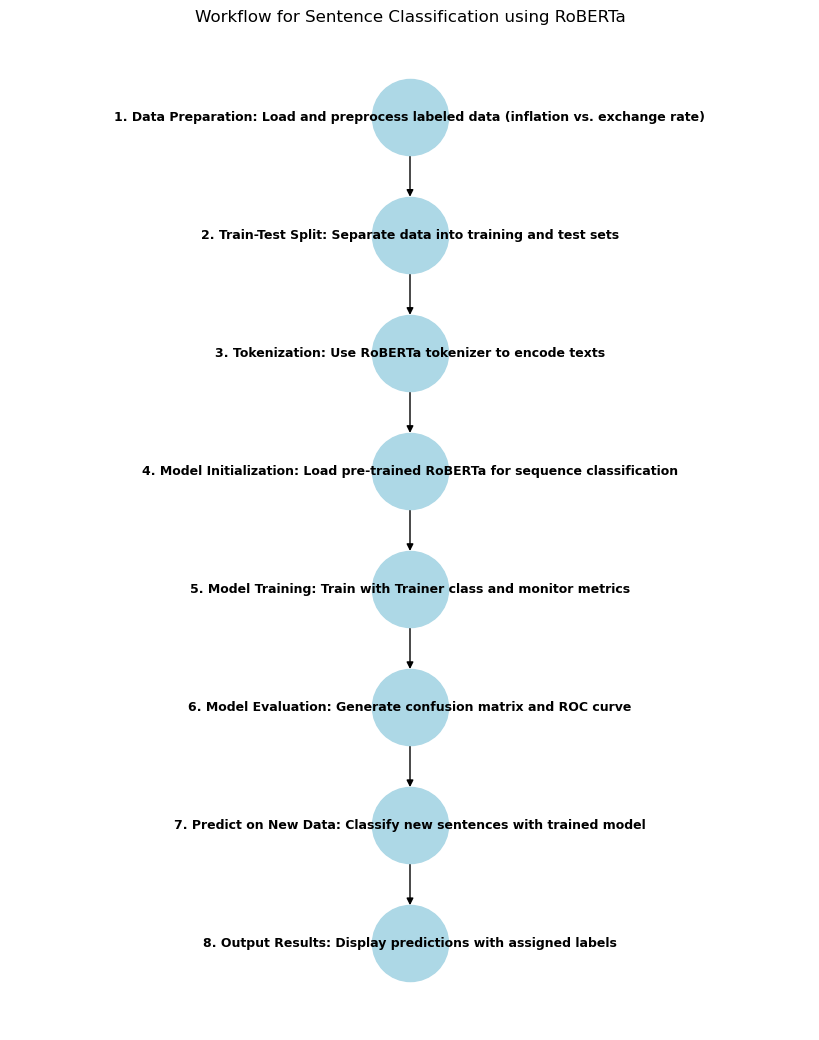

In [20]:
# Workflow Summary 
import matplotlib.pyplot as plt
import networkx as nx

# Define steps in the workflow
workflow_steps = [
    "1. Data Preparation: Load and preprocess labeled data (inflation vs. exchange rate)",
    "2. Train-Test Split: Separate data into training and test sets",
    "3. Tokenization: Use RoBERTa tokenizer to encode texts",
    "4. Model Initialization: Load pre-trained RoBERTa for sequence classification",
    "5. Model Training: Train with Trainer class and monitor metrics",
    "6. Model Evaluation: Generate confusion matrix and ROC curve",
    "7. Predict on New Data: Classify new sentences with trained model",
    "8. Output Results: Display predictions with assigned labels"
]

# Create a directed graph
workflow_graph = nx.DiGraph()
for i in range(len(workflow_steps) - 1):
    workflow_graph.add_edge(workflow_steps[i], workflow_steps[i + 1])

# Position nodes in a straight vertical line
pos = {workflow_steps[i]: (0, -i) for i in range(len(workflow_steps))}

# Draw the graph in a vertical straight line
plt.figure(figsize=(8, 10))
nx.draw(workflow_graph, pos, with_labels=True, font_size=9, node_size=3000, node_color="lightblue", font_weight="bold", arrows=True)
plt.title("Workflow for Sentence Classification using RoBERTa")
plt.axis("off")
plt.show()
